In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base= automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(list(Base.classes.keys()))

['measurement', 'station']


In [7]:
# Save references to each table
table_references={}
for table_name, table_class in Base.classes.items():
    table_references[table_name]= table_class
    print(table_name, table_class)

measurement <class 'sqlalchemy.ext.automap.measurement'>
station <class 'sqlalchemy.ext.automap.station'>


In [8]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(table_references['measurement'].date)).all()

most_recent_date

[('2017-08-23',)]

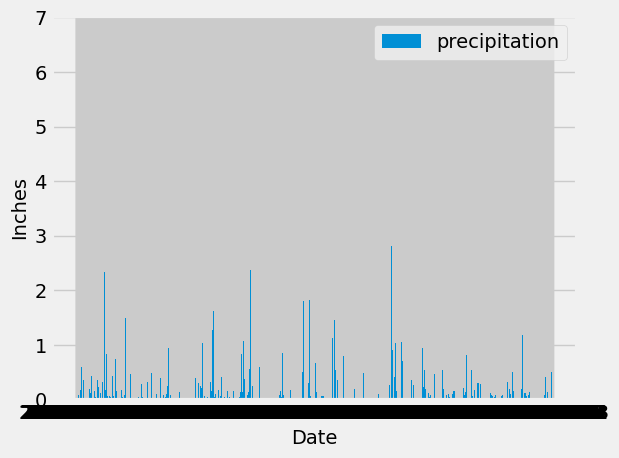

In [61]:
# ??????
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(table_references['measurement'].date)).scalar()
most_recent_date= datetime.strptime(most_recent_date ,'%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago= most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results= session.query(table_references['measurement'].date, table_references['measurement'].prcp).filter(
    table_references['measurement'].date >= one_year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df= pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df= df.sort_values(by= 'date')

# Use Pandas Plotting with Matplotlib to plot the data ???
x_indexs= np.arange(len(df))

plt.bar(x_indexs, df['precipitation'], label='precipitation')
# df.plot(x='date', y='precipitation', kind='bar')
plt.xticks(ticks= x_indexs, labels= df['date'])


plt.xlabel('Date')
plt.ylabel('Inches')

plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# ????
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].describe().to_frame()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
total_stations= session.query(func.count(table_references['station'].station)).all()
total_stations

[(9,)]

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations= session.query(
    table_references['measurement'].station,
    func.count(table_references['measurement'].station).label('station_count')
).group_by(table_references['measurement'].station).order_by(func.count(table_references['measurement'].station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station= session.query(
    table_references['measurement'].station,
    func.count(table_references['measurement'].station).label('station_count')
).group_by(table_references['measurement'].station).order_by(func.count(table_references['measurement'].station).desc()).first()

most_active_station_code= most_active_station.station

result = session.query(
    func.min(table_references['measurement'].tobs).label('min_temp'),
    func.max(table_references['measurement'].tobs).label('max_temp'),
    func.avg(table_references['measurement'].tobs).label('avg_temp')
).filter(table_references['measurement'].station == most_active_station_code).all()

result

[(54.0, 85.0, 71.66378066378067)]

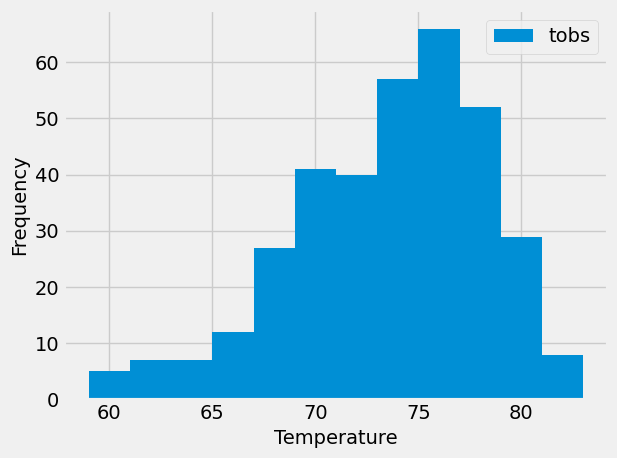

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(table_references['measurement'].tobs).filter(
    table_references['measurement'].station == most_active_station_code,
    table_references['measurement'].date >= one_year_ago
).all()

temp_df= pd.DataFrame(temperature_data, columns=['Temperature'])
plt.hist(temp_df['Temperature'], bins=12, label= 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()